# EELS SFO Project - PCA
**Description about data**






Total of 90,000 spectra was provided: 
- 2 sets of 10 spectrum images with 300 x 30 spatial coordinates.
- Each spatial coordinate has 3710 energy channels. 
- For each spectra, the initial energy-loss value is 387.5 eV with energy width of 0.125 eV i.e. [387.5 : 851.25 : 0.125].

> initial state (SrFeO3 with Fe4+) 

> annealed state (SrFeO2.5 with Fe3+)

These two sets are provided to train an ML model. The goal is that this model will take any spectral data (single spectrum with very small number of signal counts) and spit out the corresponding oxidation states (4+/3+). So one way to test this is by sampling from the 90,000 spectral data to be predicted and cross validate. The question can be: (1) what is the lowest number of spectra needed before the model can no longer distinguish, (2) what is the fastest scan speed, (3) resistant to noise, ... and so on with the same idea.

* This would be considered supervised learning. But what Josh is doing is to see how the spectra changes over the image (in their spatial distribution). ML will tells you the statistical relationship/distribution within the image.


## Some resources to read on PCA

* https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
* https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491
* http://www.swst.org/wp/meetings/AM07/labbe.pdf


* https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
* https://faithfull.me/using-pca-when-there-are-less-samples-than-dimensions/
* https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca


* https://www.nature.com/articles/nmeth.4346.pdf?proof=true

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hyperspy.api as hs
import scipy
import seaborn as sns

In [237]:
'''
loading initial data
'''
data_initial = hs.load(r'G:\Shared drives\Datasets\High-Speed EELS\Initial SIs\*.dm4', signal_type="EELS", stack=False)
print(data_initial[0].metadata)
print(data_initial[0].axes_manager)

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       ├── aperture_size = 5.0
│       │       ├── collection_angle = 45.0
│       │       ├── dwell_time = 0.00246016
│       │       ├── frame_number = 1
│       │       └── spectrometer = Drexel GIF Quantum
│       ├── Stage
│       │   ├── tilt_alpha = 5.050000190734863
│       │   ├── tilt_beta = 12.869999885559082
│       │   ├── x = -0.7727048750000001
│       │   ├── y = -0.06427769921875
│       │   └── z = 0.03934330078125
│       ├── acquisition_mode = STEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 200.0
│       ├── camera_length = 30.0
│       ├── convergence_angle = 9.0
│       ├── magnification = 600000.0
│       └── microscope = JEOL COM
├── General
│   ├── date = 2019-09-19
│   ├── original_filename = EELS Spectrum Image_00.dm4
│   ├── time = 18:40:33
│   └── title = EELS Spectrum Image_00
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │   

In [238]:
'''
loading annealed data
'''
data_anneal = hs.load(r'G:\Shared drives\Datasets\High-Speed EELS\annealed SIs\*.dm4', signal_type="EELS", stack=False)
print(data_anneal[0].metadata)
print(data_anneal[0].axes_manager)

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       ├── aperture_size = 5.0
│       │       ├── collection_angle = 45.0
│       │       ├── dwell_time = 0.00246016
│       │       ├── frame_number = 1
│       │       └── spectrometer = Drexel GIF Quantum
│       ├── Stage
│       │   ├── tilt_alpha = -9.34000015258789
│       │   ├── tilt_beta = 0.6800000071525574
│       │   ├── x = -0.8281486875
│       │   ├── y = -0.073643
│       │   └── z = 0.0213675
│       ├── acquisition_mode = STEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 200.0
│       ├── camera_length = 30.0
│       ├── convergence_angle = 9.0
│       ├── magnification = 600000.0
│       └── microscope = JEOL COM
├── General
│   ├── date = 2019-09-19
│   ├── original_filename = EELS Spectrum Image_00.dm4
│   ├── time = 20:59:46
│   └── title = EELS Spectrum Image_00
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor =

In [239]:
'''
setting x-axis label
'''
for spectra in data:
    corrected_xaxis = np.array([0.125*j+387.5 for j in range(spectra.data.shape[2])])
    #print(corrected_xaxis)

In [240]:
'''
Adding dark references to spectra
'''
def add_dark_ref(data, dark_ref):
    for k, spectra in enumerate(data):
        y = len(spectra.data)
        x = len(spectra.data[0])
        data[k].corrected = np.float32(np.copy(spectra.data))
        for i in range(y):
            for j in range(x):
                data[k].corrected[i][j] = np.sum([spectra.data[i][j],dark_ref.data], axis=0)
        #print("Completed "+str(k))
    print("Completed")

In [241]:
dark_ref = hs.load(r'G:\Shared drives\Datasets\High-Speed EELS\dark reference.dm4', signal_type="EELS")
print("Shape of dark ref spectra: " + str(dark_ref.data.shape))

add_dark_ref(data_initial, dark_ref)
add_dark_ref(data_anneal, dark_ref)

Shape of dark ref spectra: (3710,)
Completed
Completed


**Background Subtraction based on power law fit**

> Fit the equation "I = A*E^r"
    * I is the measured intensity, 
    * A is a constant
    * E is the energy-loss value (eV)
    * r is an exponent (usually around 3)
Select an energy window (around 50 eV wide), a few eV before the edge of interest to fit A and r

In [242]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)

https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes
https://scipy-cookbook.readthedocs.io/items/FittingData.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(400,1000,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].adjusted = subtractExpBackground(spectra.corrected,backgroundregion)
        data[k].SG_filter = scipy.signal.savgol_filter(data[k].adjusted, 51, 3) # window size 50, polynomial order 3

In [243]:
subtract_bckgrnd_and_filter(data_initial)
subtract_bckgrnd_and_filter(data_anneal)

In [244]:
'''
generating FFT dataset

You can plot this out. What you will see in this dataset however is that 
there is no real patterns of noise that must be removed i.e. after doing 
FTT, you may be able to pick out certain features in the graph that may
correspond to noise to be removed.

"The output of the FFT is a complex vector containing information about 
the frequency content of the signal. The magnitude tells you the strength 
of the frequency components relative to other components. The phase tells 
you how all the frequency components align in time." ~ Mathworks.com
'''
def apply_FFT(data):
    for k,spectra in enumerate(data): 
        # Applying fast fourier transform
        data[k].FFT = fft(data[k].SG_filter)
        #print("enumerated "+str(k))
    print("Completed")

In [245]:
#apply_FFT(data_initial)
#apply_FFT(data_anneal)
#plt.plot(data_initial[0].FFT)
#plt.plot(data_anneal[0].FFT)

In [246]:
'''
Downsampling the image 
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean
'''
def downsample(data, N):
    from scipy.signal import resample
    
    for k,sp in enumerate(data):
        data[k].resample = np.zeros((sp.SG_filter.shape[0],sp.SG_filter.shape[1], N))
        for i in range(sp.SG_filter.shape[0]):
            for j in range(sp.SG_filter.shape[1]):
                data[k].resample[i][j] = resample(sp.SG_filter[i][j][:], N)      


In [247]:
N = 1500  # number of samples in the resampled set

downsample(data_initial, N)
downsample(data_anneal, N)

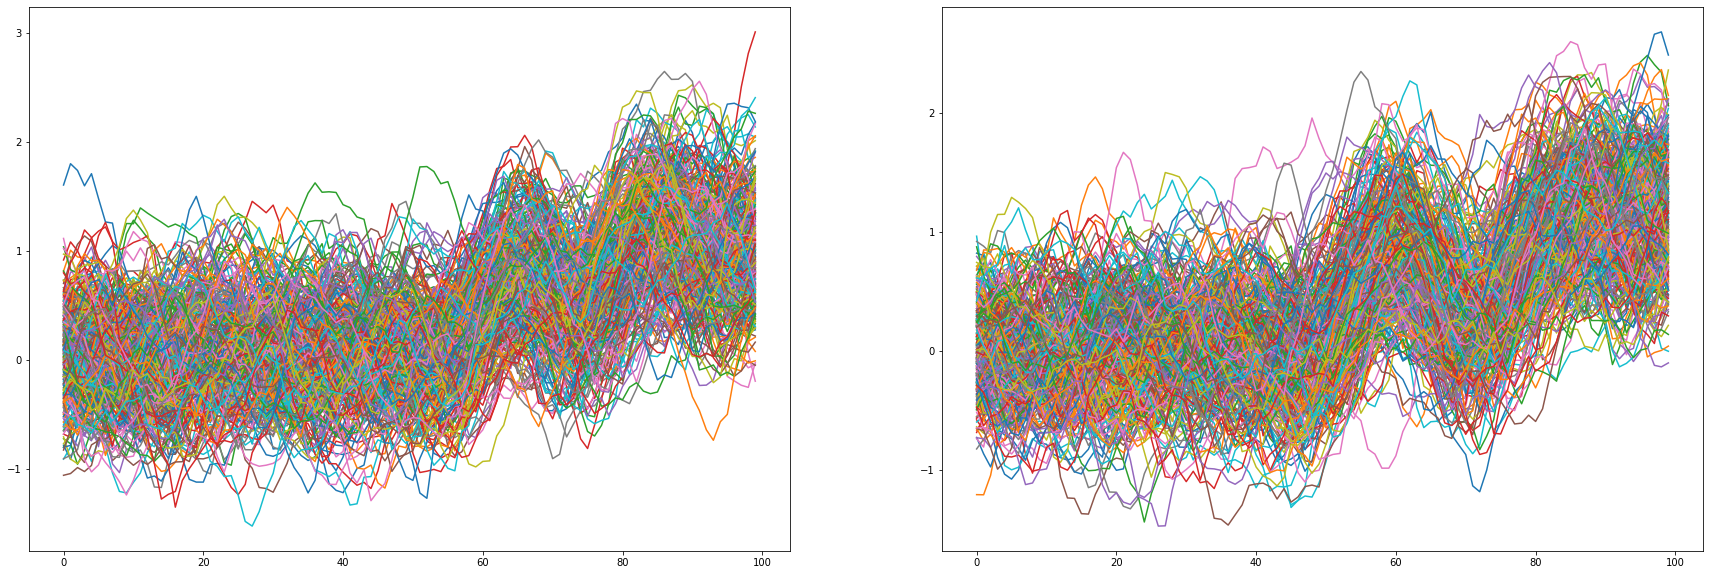

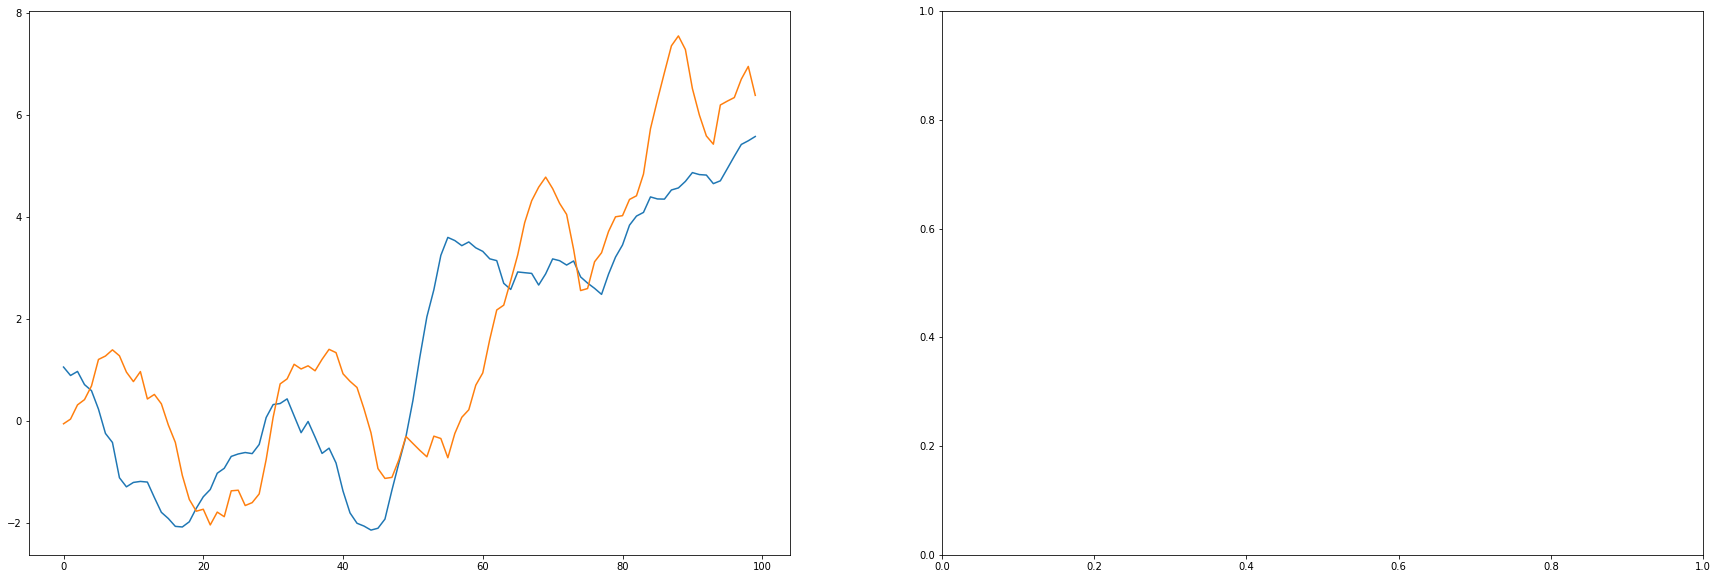

In [442]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(30,10))
for i in data_anneal[3].resample[20]:
    ax1.plot(i[400:500])
for i in data_initial[3].resample[20]:
    ax2.plot(i[400:500])
    
f,(ax1,ax2) = plt.subplots(1,2, figsize=(30,10))
ax1.plot(np.sum(data_initial[3].resample[20][30:35], axis=0)[400:500])
ax1.plot(np.sum(data_anneal[3].resample[20][30:35], axis=0)[400:500])

In [386]:
'''
aggregate data along 2D space
'''
def aggre_plot(data, N, name:str=''):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = 1500  # number resampled (have to match previous resampling rate)
    anly_range = 100
    
    exp_adjusted_data = {}
    aggregated_data_x = {}
    aggregated_data_xy = {}
    for k,spectra in enumerate(data):
        exp_adjusted_data[k] = spectra.resample
        aggregated_data_x[k] = sum(exp_adjusted_data[k]).transpose()
        aggregated_data_xy[k] = np.sum(aggregated_data_x[k],axis=1)
        #print("Shape of XY aggregate: ", str(k), str(aggregated_data_xy[k].shape))

    '''
    plot aggregated spectral data
    '''
    new_xaxis = np.linspace(387.5, 783.75, num=N)  # This is the range of energy loss given by the EELS machine
    for k,key in enumerate(aggregated_data_xy):
        ax1.plot(new_xaxis, aggregated_data_xy[key], label='spectra '+str(key))
        ax2.plot(aggregated_data_xy[key][math.ceil(1100/N_0*N_1):math.ceil((1100+anly_range)/N_0*N_1)], label='O K-edge'+name) # O K-edge 
        ax3.plot(aggregated_data_xy[key][math.ceil(2550/N_0*N_1):math.ceil((2700+anly_range)/N_0*N_1)], label='Fe L-edge'+name) # Fe L-edge
        #ax2.plot(corrected_xaxis[1000:1500], aggregated_data_xy[key][1000:1500], label='O K-edge') # O K-edge 
        #ax3.plot(corrected_xaxis[2500:3000], aggregated_data_xy[key][2500:3000], label='Fe L-edge') # Fe L-edge
        if k>5:
            break

    '''
    configure the plot
    '''
    ax1.set_title("Average Energy Loss")
    #ax1.title.set_text('Overall')
    #ax2.title.set_text('Over O peaks')
    #ax3.title.set_text('Over Fe Peaks')
    #ax4.title.set_text('Except the first few eV')
    plt.xlabel("Energy Loss (eV)")
    plt.ylabel("counts")
    #plt.legend()

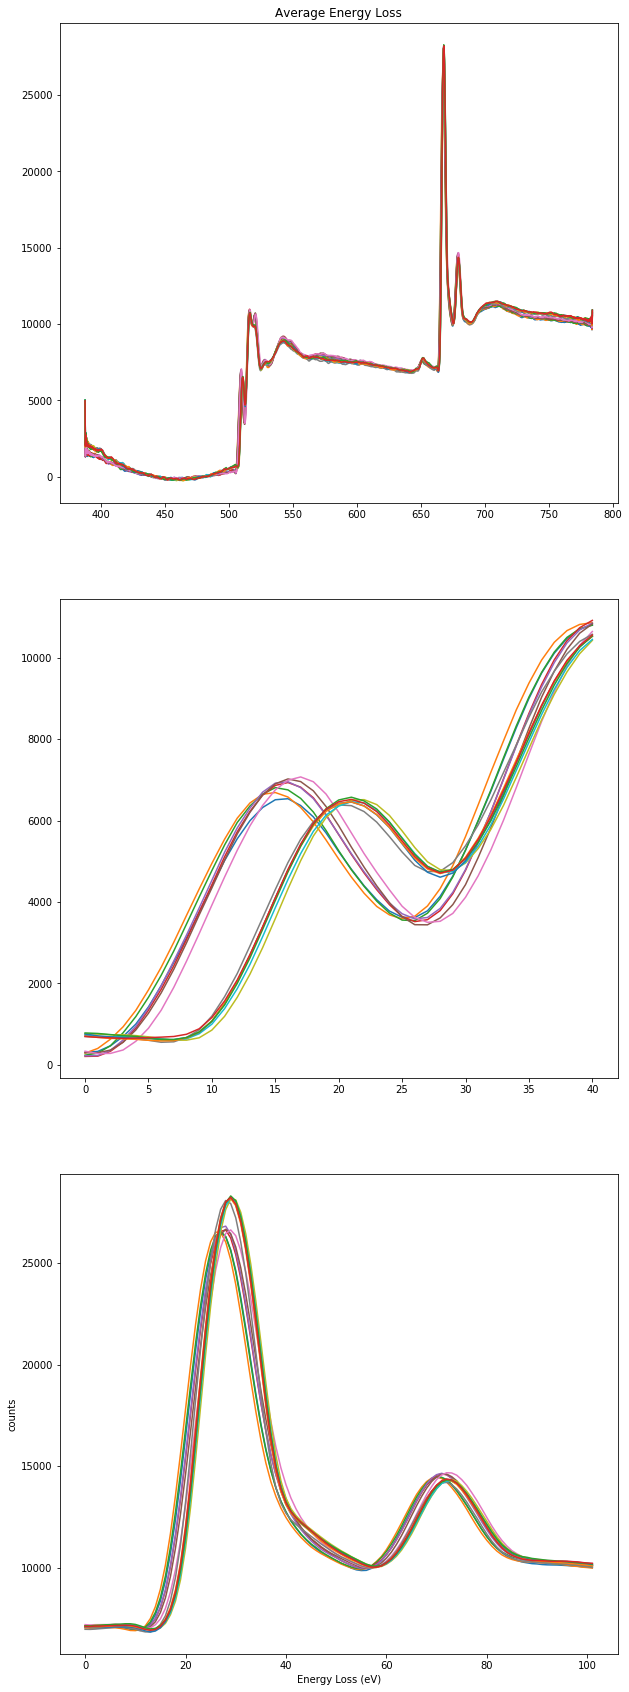

In [387]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
aggre_plot(data_initial, N, name='Initial')
aggre_plot(data_anneal, N, name='Anneal')
plt.show()

## Principle Component Analysis
- PCA on the 2 regions 
- reconstructing eigen components into 30x300 image & deconstruct again using PCA 

Essentially, I'm trying to use varience to explain my data. 

### Procedure
1. perform PCA on all 20 spectral sets
2. plot the variations of components
3. plot embeddings

In [250]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [252]:
''' 
Normalizing data over the 2 regions of interest
https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes/__init__.py
'''

def normalize(data, data_normal=None,extra_output=None):
    """
    Normalizes the data
    Parameters
    ----------
    data : numpy, array
        data to normalize
    data_normal : numpy, (optional)
        data set to normalize with
    Returns
    -------
    data_norm : numpy, array
        Output of normalized data
    """

    if data_normal is None:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_norm.reshape(-1)))
        data_norm -= mean
        std = np.std(data_norm)
        data_norm /= std
    else:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_normal.reshape(-1)))
        data_norm -= mean
        std = np.std(data_normal)
        data_norm /= std
    if extra_output==None:
        return data_norm
    else:
        return data_norm, std, mean

In [253]:
for k,spectra in enumerate(data_initial):
    data_initial[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)
for k,spectra in enumerate(data_anneal):
    data_anneal[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)

In [254]:
#data_initial[0].data_norm.reshape((-1,ogshape[2])).shape

In [388]:
'''
Cutting region of interest to be analyzed
-----------------------

anly_range = 400 raw data points
O_range = starts @ 1100 [1100:1500]
Fe_range = starts @ 2500 [2500:2900]

'''
def cut_ROI(data):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = 1500  # number resampled (have to match previous resampling rate)
    anly_range = 100

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((sp.data_norm.shape[0],sp.data_norm.shape[1], math.ceil((anly_range)/N_0*N_1)))
        data[k].Fe_range = np.zeros((sp.data_norm.shape[0],sp.data_norm.shape[1], math.ceil((anly_range)/N_0*N_1)))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][math.ceil(1100/N_0*N_1):math.ceil((1100+anly_range)/N_0*N_1)]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][math.ceil(2500/N_0*N_1):math.ceil((2500+anly_range)/N_0*N_1)]

In [389]:
cut_ROI(data_initial)
cut_ROI(data_anneal)

In [390]:
'''
Fitting the PCA
'''

numPCAcomp = 25

def plot_PCA(peak, stack=[], numPCAcomp=25):
    if stack ==[]:
        raise('stack must be given as list of datasets')
    x = np.linspace(1, numPCAcomp, numPCAcomp)
    plt.figure()
    for data in stack:
        for k,spectra in enumerate(data):    
            # selecting range to analyze    
            if peak =='fe':
                scope = data[k].Fe_range
            elif peak =='o':
                scope = data[k].O_range
            else:
                raise('peak type not specify: fe/o')
            linear_scope = scope.reshape((-1,scope.shape[2]))  # 2D reduced 30x300 to 9000 linear 

            #Fitting the PCA algorithm with our Data
            pca = PCA(n_components=numPCAcomp, copy=True, svd_solver='auto', tol=0.0)
            pca.fit(linear_scope)
            #Apply dimensionality reduction to analysis range; reshape the scope back to 30x300
            PCA_Embeddings = pca.transform(linear_scope).reshape((scope.shape[0],scope.shape[1],-1))
            #Plotting the Cumulative Summation of the Explained Variance
            plt.plot(x, np.cumsum(pca.explained_variance_ratio_), color='b')
            plt.plot(x, [0.95]*numPCAcomp, color='r')

            # print(linear_scope.shape)
            # print(PCA_Embeddings.shape)

    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Variance')
    plt.show()
    return pca, PCA_Embeddings

In [391]:
scope = np.array([data_initial[0].Fe_range, data_anneal[0].Fe_range])
scope.shape

(2, 30, 300, 41)

In [392]:
scope2 = scope.reshape((-2,scope.shape[3]))
scope2.shape

(18000, 41)

In [393]:
scope3 = scope2.reshape((scope.shape[1],scope.shape[2],-1))
scope3.shape

(30, 300, 82)

In [394]:
'''
Fitting the PCA
'''

def plot_PCA(peak, stack=[], numPCAcomp=25):
    if len(stack) != 2:
        raise('stack must be given as list of 2 datasets')
    x = np.linspace(1, numPCAcomp, numPCAcomp)
    plt.figure()
    for k in range(len(stack[0])):    
        # selecting range to analyze    
        if peak =='fe':
            scope = np.array([stack[0][k].Fe_range, stack[1][k].Fe_range])
        elif peak =='o':
            scope = np.array([stack[0][k].O_range, stack[1][k].O_range])
        else:
            raise('peak type not specify: fe/o')
        linear_scope = scope.reshape((-2,scope.shape[3]))  # 2D reduced 30x300 to 9000 linear 

        #Fitting the PCA algorithm with our Data
        pca = PCA(n_components=numPCAcomp, copy=True, svd_solver='auto', tol=0.0)
        pca.fit(linear_scope)
        #Apply dimensionality reduction to analysis range; reshape the scope back to 30x300
        PCA_Embeddings = pca.transform(linear_scope).reshape((scope.shape[1],scope.shape[2],-1))
        #Plotting the Cumulative Summation of the Explained Variance
        plt.plot(x, np.cumsum(pca.explained_variance_ratio_), color='b')
        plt.plot(x, [0.95]*numPCAcomp, color='r')

        # print(linear_scope.shape)
        # print(PCA_Embeddings.shape)

    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Variance')
    plt.show()
    return pca, PCA_Embeddings

In [407]:
numPCAcomp = 8

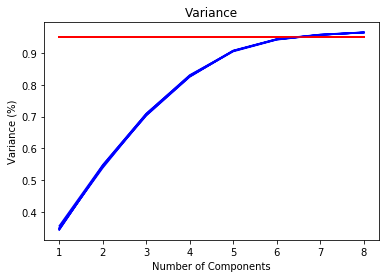

In [408]:
pca, PCA_Embeddings = plot_PCA('o',[data_initial, data_anneal], numPCAcomp)

In [418]:
'''
Plotting out the variance across 30x300 map

At this point, the remaining numPCAcomp are supposed to be the best N features to describe the data.
This is plotted in the next cell to show any similar components across the embeddings
'''
def plot_Var(PCA_Embeddings, numPCAcomp=25):
    Embedding_Variance = [np.var(PCA_Embeddings[:,:,i]) for i in range(numPCAcomp)]
    plt.plot(Embedding_Variance, color='b')    
    plt.xlabel('Component')
    plt.ylabel('Variance (%)') #for each component
    plt.title("Variance of each component across 30x300 map")
    plt.show()

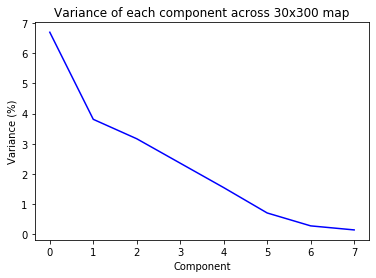

In [419]:
plot_Var(PCA_Embeddings, numPCAcomp)

In [414]:
'''
Plotting out the similarity for each embedding
'''

#import matplotlib as m
#cdict = {
#  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
#}
#cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def plot_embeddings(PCA_Embeddings,numPCAcomp=25):
    fig= plt.figure(figsize=(20,20))
    ax=[]

    for i in range(numPCAcomp):
        ax.append(fig.add_subplot(5,5,i+1))
        # plotting pseudocolor with global min/max scale
        pcolor=ax[-1].pcolor(PCA_Embeddings[:,:,i])
                             #vmin=np.amin(PCA_Embeddings), 
                             #vmax=np.amax(PCA_Embeddings),
                             #cmap=cm
        ax[i].set_title('Component = '+str(i))
        #ax[-1].axis('scaled')
        ax[-1].invert_yaxis()
        #pcolor.set_clim(0, 2)
        fig.colorbar(pcolor)

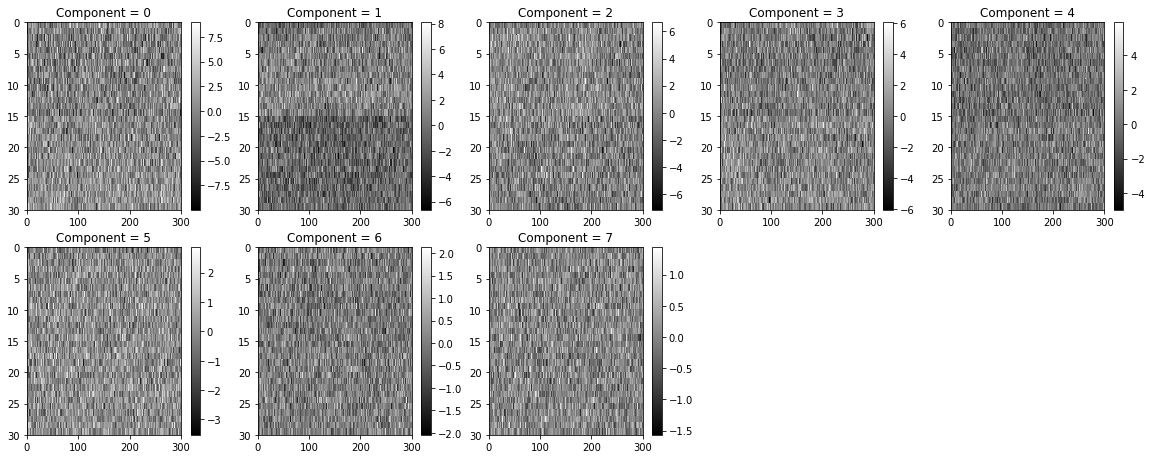

In [415]:
plot_embeddings(PCA_Embeddings,numPCAcomp)

In [402]:
def plot_eigenvalues(pca,trainingforML):
    fig= plt.figure(figsize=(3,3))
    ax=fig.subplots(1,1)
    ax.plot(pca.mean_,color=[0,0,0,1])
    ax.set_title('Average')
    fig.tight_layout()

    eigenvectors=pca.components_
    fig= plt.figure(figsize=(12,12))
    ax=[]

    X=copy.deepcopy(trainingforML.reshape(-1,trainingforML.shape[2]))
    n_samples = X.shape[0]
    # We center the data and compute the sample covariance matrix.
    X -= np.mean(X, axis=0)
    cov_matrix = np.dot(X.T, X) / n_samples

    for i,eigenvector in enumerate(eigenvectors):
        ax.append(fig.add_subplot(5,5,i+1))
        for j,c in enumerate(eigenvectors):
            ax[i].plot(c,color=[0.5,0.5,0.5,0.5])
        ax[i].plot(eigenvector,color=[1,0,0,1])
        Eigenvalue=np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
        ax[i].set_title('Eigenvalue = '+str(round(Eigenvalue,3)))
    fig.tight_layout()

ValueError: shapes (162,162) and (41,) not aligned: 162 (dim 1) != 41 (dim 0)

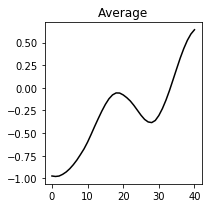

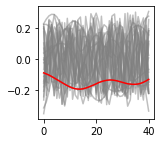

In [404]:
#TODO: fix the trainingforML dimension

trainingforML = data[0].Fe_range

plot_eigenvalues(pca,trainingforML)

## Conclusion

At this point, PCA seems to yield no significant result. It fails to extract information for several reasons + backed by several evidence.


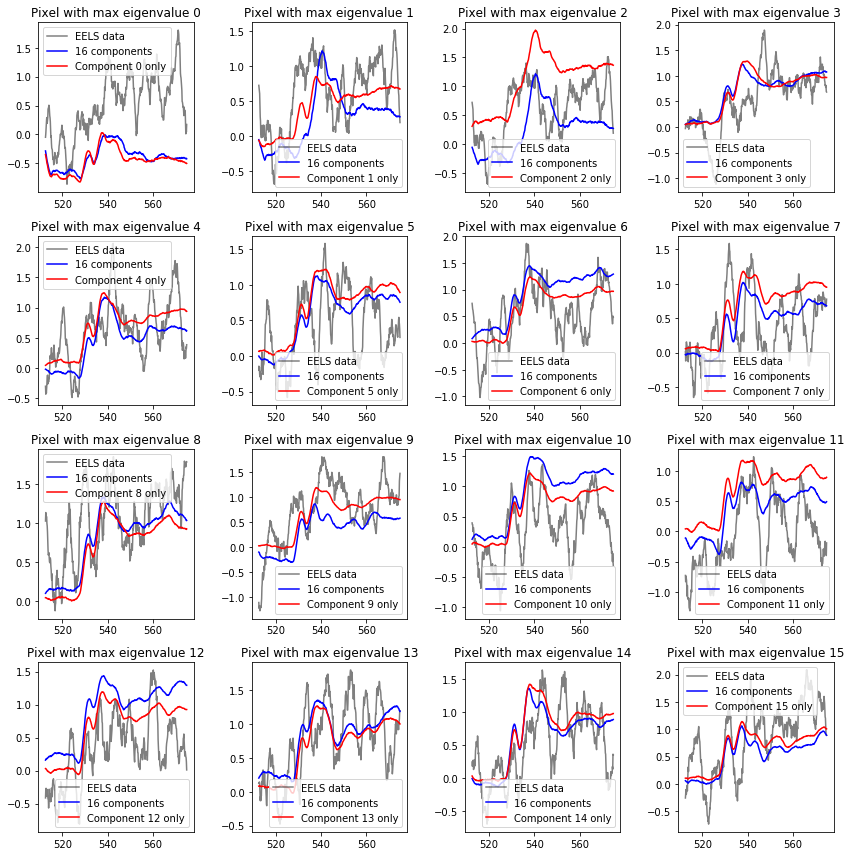

In [161]:
eigenvectors=PCA.components_
fig= plt.figure(figsize=(12,12))
ax=[]
#fig.suptitle('Datapoints with highest score for each component')


# iterate through each eigenvalue
for i,eigenvector in enumerate(eigenvectors):
    ax.append(fig.add_subplot(4,4,i+1))
    
    indexes=np.unravel_index(np.argmax(PCAembeddings[:,:,i], axis=None), PCAembeddings[:,:,i].shape)
    # Explanation of unravel_index: https://stackoverflow.com/a/48138599/8742400 
    # ax[i].text(550,3,indexes)
    ax[i].plot(corrected_xaxis[1000:1500],trainingforML[indexes][1000:1500],color=[0,0,0,0.5],label='EELS data')
    
    # Plotting prediction based on all components (in blue)
    predicted=np.dot(PCAembeddings[indexes], eigenvectors)+PCA.mean_
    ax[i].plot(corrected_xaxis[1000:1500],predicted[1000:1500],color=[0,0,1,1],label=str(numPCAcomp)+' components')
    
    # Plotting prediction based on single component (in red)
    weight=PCAembeddings[indexes][i]
    predicted_with_single_comp = eigenvector*weight+PCA.mean_
    ax[i].plot(corrected_xaxis[1000:1500],predicted_with_single_comp[1000:1500],color=[1,0,0,1],label='Component '+str(i)+' only')
    
    ax[i].set_title('Pixel with max eigenvalue '+str(i))
    ax[i].legend()
fig.tight_layout()